# Teilur Stock Agent — UAT Notebook

End-to-end demonstration of the deployed Teilur Stock Agent:

1. **Section 1** — Authenticate against AWS Cognito (no AWS credentials required)
2. **Section 2** — Execute the 5 acceptance queries with live streaming
3. **Section 3** — Langfuse observability traces

**Architecture:** Python ReAct agent (LangGraph + Amazon Nova Pro via Bedrock) deployed on AWS AgentCore Runtime, secured with Cognito JWT authorization, traced with Langfuse.

---

### Prerequisites

Install the single required dependency:

```bash
pip install httpx
```

No AWS credentials or local configuration needed — all values are pre-filled below.

---

In [1]:
# ── Imports & Configuration ─────────────────────────────────────────────────
import httpx
import json
import uuid
import os

# ── Cognito ──────────────────────────────────────────────────────────────────
COGNITO_REGION       = "us-east-1"
COGNITO_USER_POOL_ID = "us-east-1_ngemulL07"
COGNITO_CLIENT_ID    = "7quopkm13gpej7ci3uevlg4a5"

USERNAME = "testuser@teilur.dev"
PASSWORD = "Teilur2026!"

# ── Live AgentCore endpoint ───────────────────────────────────────────────────
# Format: https://bedrock-agentcore.{region}.amazonaws.com/runtimes/{url-encoded-arn}/invocations?qualifier=DEFAULT
AGENT_ENDPOINT = (
    "https://bedrock-agentcore.us-east-1.amazonaws.com"
    "/runtimes/arn%3Aaws%3Abedrock-agentcore%3Aus-east-1%3A531241048046"
    "%3Aruntime%2Fteilur_stock_agent-pTabPe3lvC/invocations?qualifier=DEFAULT"
)

print("Configuration loaded.")
print(f"  Cognito User Pool : {COGNITO_USER_POOL_ID}")
print(f"  Agent Endpoint    : {AGENT_ENDPOINT[:80]}...")

Configuration loaded.
  Cognito User Pool : us-east-1_ngemulL07
  Agent Endpoint    : https://bedrock-agentcore.us-east-1.amazonaws.com/runtimes/arn%3Aaws%3Abedrock-a...


---
## Section 1 — Cognito User Authentication

The cell below calls the Cognito `InitiateAuth` endpoint directly over HTTPS using `httpx` — no AWS SDK or local credentials required.

Cognito's `USER_PASSWORD_AUTH` flow for app clients without a client secret is a public endpoint: it does not require AWS SigV4 signing.

In [2]:
# ── Section 1: Authenticate with Cognito ─────────────────────────────────────
async with httpx.AsyncClient(timeout=30.0) as client:
    resp = await client.post(
        f"https://cognito-idp.{COGNITO_REGION}.amazonaws.com/",
        headers={
            "X-Amz-Target": "AWSCognitoIdentityProviderService.InitiateAuth",
            "Content-Type": "application/x-amz-json-1.1",
        },
        json={
            "AuthFlow": "USER_PASSWORD_AUTH",
            "ClientId": COGNITO_CLIENT_ID,
            "AuthParameters": {
                "USERNAME": USERNAME,
                "PASSWORD": PASSWORD,
            },
        },
    )
    resp.raise_for_status()
    auth_data = resp.json()

id_token = auth_data["AuthenticationResult"]["IdToken"]

print("Authentication successful!")
print(f"  User       : {USERNAME}")
print(f"  User Pool  : {COGNITO_USER_POOL_ID}")
print(f"  Token type : id (Bearer)")
print(f"  ID Token   : {id_token[:60]}...")

Authentication successful!
  User       : testuser@teilur.dev
  User Pool  : us-east-1_ngemulL07
  Token type : id (Bearer)
  ID Token   : eyJraWQiOiJXZFlXYXNPWFYxdjFlaHdKeVFTcHI3clJTK2RtSDdSaE95ckQx...


---
## Section 2 — UAT Queries

The `query_agent` helper streams each query to the live AgentCore endpoint.

| # | Query | Expected tools |
|---|---|---|
| 1 | Real-time AMZN price | `retrieve_realtime_stock_price` |
| 2 | Q4 historical prices | `retrieve_historical_stock_price` |
| 3 | Performance vs analyst reports | both stock tools + `retrieve_financial_documents` |
| 4 | Current price + AI business | `retrieve_realtime_stock_price` + `retrieve_financial_documents` |
| 5 | Office space (knowledge-base) | `retrieve_financial_documents` |

In [3]:
# ── Streaming helper ──────────────────────────────────────────────────────────
async def query_agent(query: str, token: str, session_id: str | None = None) -> None:
    """Stream a query to the AgentCore endpoint and display the response."""
    if session_id is None:
        session_id = str(uuid.uuid4())

    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json",
        # AgentCore requires a session ID of at least 33 characters (UUID = 36 chars)
        "X-Amzn-Bedrock-AgentCore-Runtime-Session-Id": session_id,
    }

    print(f"{'─' * 70}")
    print(f"Query: {query}")
    print(f"{'─' * 70}")

    try:
        async with httpx.AsyncClient(timeout=180.0) as client:
            async with client.stream(
                "POST", AGENT_ENDPOINT, headers=headers, json={"prompt": query}
            ) as response:
                response.raise_for_status()
                async for line in response.aiter_lines():
                    if not line.startswith("data: "):
                        continue
                    raw = line[6:]
                    if raw == "[DONE]":
                        break
                    try:
                        event = json.loads(raw)
                    except json.JSONDecodeError:
                        continue

                    node    = event.get("node", "")
                    content = event.get("content", "")
                    etype   = event.get("type", "")

                    if node == "llm_node" and isinstance(content, list):
                        # LLM reasoning step — show which tools are being called
                        for part in content:
                            if isinstance(part, dict) and part.get("type") == "tool_use":
                                print(f"  → Calling tool: {part['name']}")
                    elif node == "llm_node" and isinstance(content, str) and content.strip():
                        # Final synthesised answer
                        print(f"\n{content}")

    except httpx.HTTPStatusError as exc:
        code = exc.response.status_code
        if code == 401:
            print("[401] Authentication failed — re-run Section 1 to refresh the token.")
        elif code == 403:
            print("[403] Forbidden — check that the Cognito authorizer is configured on the runtime.")
        else:
            print(f"[{code}] {exc}")
    except httpx.TimeoutException:
        print("[Timeout] Request exceeded 180 s — check Langfuse for trace details.")
    except Exception as exc:
        print(f"[Error] {type(exc).__name__}: {exc}")

    print()

print("Helper ready.")

Helper ready.


In [4]:
# ── Query 1: Real-time stock price ───────────────────────────────────────────
await query_agent(
    "What is the stock price for Amazon right now?",
    id_token,
    session_id=str(uuid.uuid4()),
)

──────────────────────────────────────────────────────────────────────
Query: What is the stock price for Amazon right now?
──────────────────────────────────────────────────────────────────────


  → Calling tool: retrieve_realtime_stock_price



The current stock price for Amazon (AMZN) is $205.27 USD. Here are the key market metrics:
- Previous close: $209.98 USD
- Open: $208.04 USD
- Day high: $208.43 USD
- Day low: $203.11 USD
- Volume: 51,669,745 shares
- Market state: POSTPOST

If you need further details or additional financial information, feel free to ask.



In [5]:
# ── Query 2: Historical prices (Q4 last year) ─────────────────────────────────
await query_agent(
    "What were the stock prices for Amazon in Q4 last year?",
    id_token,
    session_id=str(uuid.uuid4()),
)

──────────────────────────────────────────────────────────────────────
Query: What were the stock prices for Amazon in Q4 last year?
──────────────────────────────────────────────────────────────────────


  → Calling tool: retrieve_historical_stock_price



Here are the stock prices for Amazon (AMZN) in Q4 of last year (October 1, 2023, to December 31, 2023):

- October 2, 2023: Opened at $127.28, closed at $129.46
- October 3, 2023: Opened at $128.06, closed at $124.72
- October 4, 2023: Opened at $126.06, closed at $127.00
- October 5, 2023: Opened at $126.71, closed at $125.96
- October 6, 2023: Opened at $124.16, closed at $127.96
- October 9, 2023: Opened at $126.22, closed at $128.26
- October 10, 2023: Opened at $128.82, closed at $129.48
- October 11, 2023: Opened at $129.74, closed at $131.83
- October 12, 2023: Opened at $132.17, closed at $132.33
- October 13, 2023: Opened at $132.98, closed at $129.79
- October 16, 2023: Opened at $130.69, closed at $132.55
- October 17, 2023: Opened at $130.39, closed at $131.47
- October 18, 2023: Opened at $129.90, closed at $128.13
- October 19, 2023: Opened at $130.57, closed at $128.40
- October 20, 2023: Opened at $128.05, closed at $125.17
- October 23, 2023: Opened at $124.63, closed

In [6]:
# ── Query 3: Stock performance vs analyst predictions ─────────────────────────
await query_agent(
    "Compare Amazon's recent stock performance to what analysts predicted in their reports",
    id_token,
    session_id=str(uuid.uuid4()),
)

──────────────────────────────────────────────────────────────────────
Query: Compare Amazon's recent stock performance to what analysts predicted in their reports
──────────────────────────────────────────────────────────────────────


  → Calling tool: retrieve_historical_stock_price
  → Calling tool: retrieve_financial_documents



Based on the retrieved data, here is a comparison of Amazon's recent stock performance to what analysts predicted:

### Recent Stock Performance (Last 3 Months)
- **Starting Price (Nov 24, 2025):** $222.56
- **Ending Price (Feb 23, 2026):** $205.27
- **Performance:** The stock price decreased by approximately 7.77% over the last 3 months.

### Analysts' Predictions
The retrieved financial documents do not provide specific stock price predictions from analysts. However, they do provide guidance on net sales and operating income for the quarters, which can be used as a proxy for overall company performance expectations.

### Summary
- **Stock Performance:** Amazon's stock price has declined by about 7.77% over the last 3 months.
- **Analyst Expectations:** While specific stock price predictions are not available, the guidance provided indicates expectations for net sales and operating income growth, which suggests a positive outlook for the company's financial performance.

In conclusio

In [7]:
# ── Query 4: Current price + AI business ─────────────────────────────────────
await query_agent(
    "I'm researching AMZN give me the current price and any relevant information about their AI business",
    id_token,
    session_id=str(uuid.uuid4()),
)

──────────────────────────────────────────────────────────────────────
Query: I'm researching AMZN give me the current price and any relevant information about their AI business
──────────────────────────────────────────────────────────────────────


  → Calling tool: retrieve_realtime_stock_price
  → Calling tool: retrieve_financial_documents



The current stock price of Amazon (AMZN) is $205.27 USD as of the latest real-time data. Here is some relevant information about Amazon's AI business:

- Amazon's mission to make customers' lives better and easier every day has led to significant investments in AI. There are more than 1,000 GenAI applications being developed across Amazon to improve customer experiences in various areas such as shopping, coding, personal assistants, streaming video and music, advertising, healthcare, reading, and home devices [Amazon-2024-Annual-Report.pdf, Page: 6].

- AWS is developing key primitives for AI development, including custom silicon AI chips like Amazon Trainium, model-building and inference services like Amazon SageMaker and Amazon Bedrock, and frontier models like Amazon Nova [Amazon-2024-Annual-Report.pdf, Page: 6].

- Recent AI-related announcements include:
  - Amazon S3 Vectors, which reduces the cost of vector storage by up to 90% [AMZN-Q2-2025-Earnings-Release.pdf, Page: 1].
  - 

In [8]:
# ── Query 5: Office space North America 2024 (knowledge-base only) ───────────
await query_agent(
    "What is the total amount of office space Amazon owned in North America in 2024?",
    id_token,
    session_id=str(uuid.uuid4()),
)

──────────────────────────────────────────────────────────────────────
Query: What is the total amount of office space Amazon owned in North America in 2024?
──────────────────────────────────────────────────────────────────────


  → Calling tool: retrieve_financial_documents



In 2024, Amazon owned 9,104 thousand square feet of office space in North America. This information is found in the Amazon 2024 Annual Report on page 29.



---
## Section 3 — Langfuse Observability

Every agent invocation is traced end-to-end by **Langfuse Cloud** (project: `teilur-stock-agent`, org: `PersonalProjects`, region: `https://us.cloud.langfuse.com`).

Each trace captures:
- The full LLM call with input messages, output, token usage, and latency
- Each tool invocation (name, arguments, result)
- The complete ReAct reasoning loop: Reason → Tool call → Observe → Final answer

> **For the reviewer:** Langfuse screenshots are embedded below in Section 3B.  
> The Langfuse project is private — the screenshots are the evidence of observability.

In [9]:
# ── Section 3A: Programmatic trace retrieval (optional) ─────────────────────
# Requires LANGFUSE_PUBLIC_KEY and LANGFUSE_SECRET_KEY environment variables.
# If not set, traces are shown as screenshots in Section 3B.

LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY", "")
LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY", "")

if LANGFUSE_PUBLIC_KEY and LANGFUSE_SECRET_KEY:
    try:
        from langfuse import get_client
        langfuse = get_client()
        traces   = langfuse.fetch_traces(limit=6)
        print(f"Latest {len(traces.data)} Langfuse traces:\n")
        for t in traces.data:
            print(f"  Trace ID : {t.id}")
            print(f"  Name     : {t.name}")
            print(f"  Latency  : {t.latency}s")
            print(f"  Input    : {str(t.input)[:100]}...")
            print(f"  Output   : {str(t.output)[:100]}...")
            print()
    except Exception as exc:
        print(f"[INFO] Could not fetch traces: {exc}")
else:
    print("LANGFUSE_PUBLIC_KEY / LANGFUSE_SECRET_KEY not set.")
    print("See Section 3B for dashboard screenshots.")

LANGFUSE_PUBLIC_KEY / LANGFUSE_SECRET_KEY not set.
See Section 3B for dashboard screenshots.


### Section 3B — Langfuse Dashboard Screenshots

The screenshots below were captured from the Langfuse dashboard after running the 5 UAT queries.

**Trace overview** — all invocations listed with latency and tool spans:  
![Langfuse trace overview](../docs/screenshots/langfuse_trace_overview.png)

**Trace detail** — LLM call, tool invocations, and final answer for a single query:  
![Langfuse trace detail](../docs/screenshots/langfuse_trace_detail.png)

── Trace overview (all 5 UAT queries)


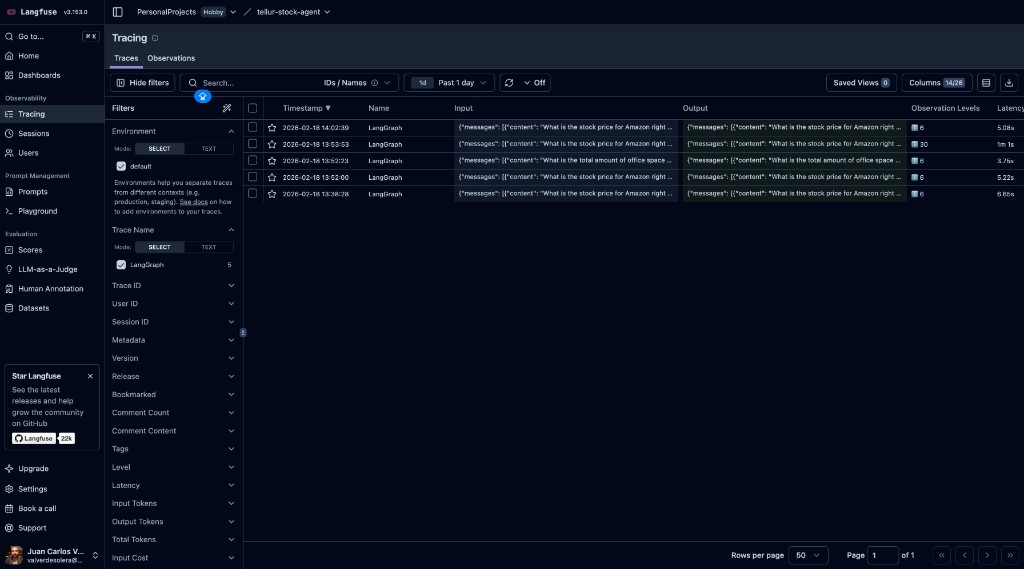

── Trace detail (LLM call + tool spans)


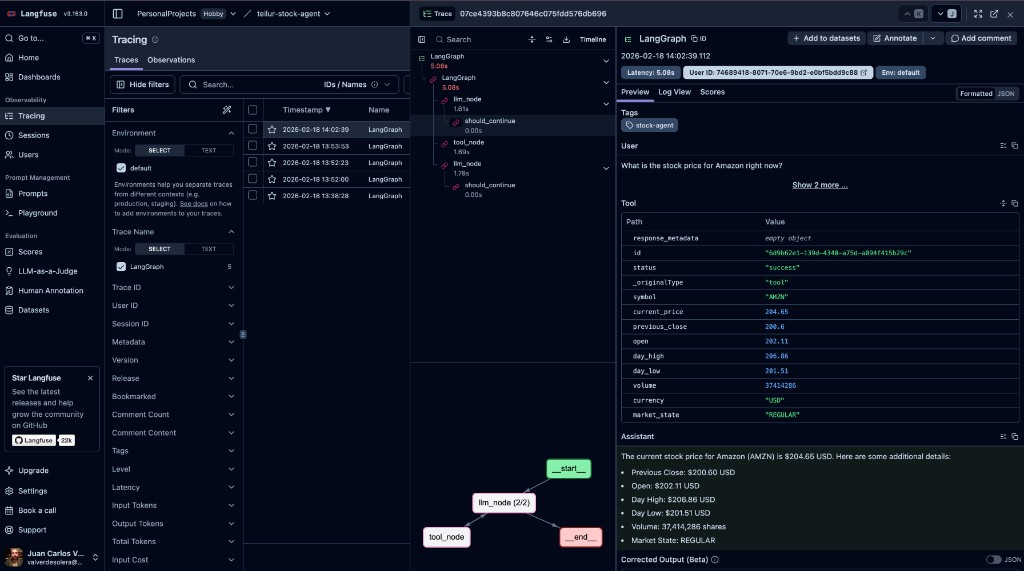

In [10]:
# ── Section 3B: Display screenshots inline ───────────────────────────────────
from IPython.display import Image, display

screenshots = {
    "Trace overview (all 5 UAT queries)": "../docs/screenshots/langfuse_trace_overview.png",
    "Trace detail (LLM call + tool spans)": "../docs/screenshots/langfuse_trace_detail.png",
}

for label, path in screenshots.items():
    if os.path.exists(path):
        print(f"── {label}")
        display(Image(filename=path, width=900))
    else:
        print(f"[Placeholder] {label}")
        print(f"  Save screenshot to: {path}")
        print()